# Neural Network for Recommender Systems

In [1]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import tensorflow_recommenders as tfrs

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [4]:
# import keras_tuner as kt

In [5]:
df = pd.read_csv('./datasets/merged_users+movies.csv')
movie_df = pd.read_csv('./datasets/movies.csv')

In [83]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure Animation Children Comedy Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure Animation Children Comedy Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure Animation Children Comedy Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure Animation Children Comedy Fantasy


In [85]:
retrieval_df = pd.read_csv('./datasets/retrieval_model_scores.csv')
ranking_df = pd.read_csv('./datasets/retrieval_model_scores.csv')

In [86]:
retrieval_dict = retrieval_df.to_dict(orient='list')
ranking_dict = ranking_df.to_dict(orient='list')

In a deep learning model, we can make use of features that we were not able to do so with our `SVD` model previously.<br>

We will attempt to create a deep learning model using all 6 features of our dataset. Namely these are: `userId`, `movieId`, `rating`, `timestamp`, `title`, `genres`.

We will be building a two step model, as is outlined in the tensorflow-recommenders guide. A retrieval model, and a ranking model. These two models will allow us to ....

We will first start with the retrieval model.

## Retrieval Model

In order to add all the features to our model, we will need to create `embeddings` for each of them. We can use the `Embedding` method in `Keras` to help with this. Let's start by first creating a tensorflow compatible dataset that we will then use for creation of any `embeddings` we need.

We will start off by converting our all our required data to a tensorflow dataset that will work with methods like `batch` and `map`.

In [7]:
retrieval_dataset = {
    'movieId': df['movieId'].tolist(),
    'genres': df['genres'].tolist(),
    'title': df['title'].tolist(),
    'userId': df['userId'].tolist(),
    'timestamp': df['timestamp'].tolist(),
}

In [8]:
retrieval_dataset = tf.data.Dataset.from_tensor_slices(retrieval_dataset)

In [9]:
# defining an empty dictionary to store the predicted ratingsaaaaaaaaaaaaaaaaaa

In [10]:
retrieval_dataset = retrieval_dataset.map(lambda x: {
    'movieId': x['movieId'],
    'genres': x['genres'],
    'title': x['title'],
    'userId': x['userId'],
    'timestamp': x['timestamp'],
})

# creating separate datasets in case we need to use them to be 
# added to the model.
movies = retrieval_dataset.map(lambda x: x['movieId'])
genres = retrieval_dataset.map(lambda x: x['genres'])
movie_titles = retrieval_dataset.map(lambda x: x['title'])
users = retrieval_dataset.map(lambda x: x['userId'])
timestamps = retrieval_dataset.map(lambda x: x['timestamp'])
movie_related = retrieval_dataset.map(lambda x: {
    'movieId': x['movieId'],
    'genres': x['genres'],
    'title': x['title']
})

In [11]:
# sanity check once again to ensure that we have 
# a 'MapDataset' object
retrieval_dataset

<MapDataset element_spec={'movieId': TensorSpec(shape=(), dtype=tf.int32, name=None), 'genres': TensorSpec(shape=(), dtype=tf.string, name=None), 'title': TensorSpec(shape=(), dtype=tf.string, name=None), 'userId': TensorSpec(shape=(), dtype=tf.int32, name=None), 'timestamp': TensorSpec(shape=(), dtype=tf.int32, name=None)}>

Now let's create the vocabularies for our `categorical` embeddings.

### MovieIds and UserIds

In [12]:
# creating a list of unique userIds
unique_user_ids = np.unique(df['userId'].tolist())

# creating a list of unique movieIds
unique_movie_ids = np.unique(df['movieId'].tolist())

In [13]:
# defining an empty dictionary to store the predicted ratingsaaaaaaaaaaaaaaaaaa

In [14]:
# defining the embedding dimension that we will use across all embedding 
# layers. We have kept this number relatively small so that the model will 
# work a little faster.
embedding_dimension = 32

In [15]:
# embedding unique userIds
user_id_model = tf.keras.Sequential([
    tf.keras.layers.IntegerLookup(
        vocabulary=unique_user_ids, mask_token=None),
    # We add some additional embeddings to account for unknown tokens.
    tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

In [16]:
# check to see the vector embedding of 'userIds'
user_id_model([512])

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[-0.03128015,  0.03438071, -0.01174592,  0.0101427 ,  0.02118118,
        -0.038535  , -0.02383973, -0.04257793,  0.04730797, -0.03115307,
         0.01441553,  0.04310058, -0.02741833, -0.0054088 , -0.03259417,
         0.04947333,  0.03272885, -0.04545831, -0.01818838,  0.04232411,
        -0.01569668, -0.04511279, -0.02215107, -0.01029055,  0.03575362,
        -0.04870703, -0.0018393 ,  0.01275836, -0.02766782,  0.03315471,
        -0.00111959, -0.03475295]], dtype=float32)>

In [17]:
# defining an empty dictionary to store the predicted ratingsaaaaaaaaaaaaaaaaaa

In [18]:
# embedding unique movie titles
movie_id_model = tf.keras.Sequential([
    tf.keras.layers.IntegerLookup(
        vocabulary=unique_movie_ids, mask_token=None), 
    # We add some additional embeddings to account for unknown tokens.    
    tf.keras.layers.Embedding(len(unique_movie_ids) + 1, 
                              embedding_dimension)
])


In [19]:
movie_id_model([9772])

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[ 0.02520246, -0.03815152, -0.04186211, -0.01645218,  0.02076913,
         0.00377073, -0.03175095, -0.03725419, -0.04842513, -0.01137273,
         0.01077969,  0.04457656,  0.01085545, -0.02769569,  0.03951421,
        -0.04472519, -0.01050532, -0.00969529,  0.00785844,  0.01408844,
        -0.00632553,  0.03473219, -0.01108712,  0.041569  ,  0.02897431,
         0.01296527,  0.02073428,  0.04186301,  0.0102808 ,  0.0402603 ,
        -0.04730649, -0.04233315]], dtype=float32)>

---

### Genres

Next we will create a `word embedding` for the genres feature.
There are 34 movies in the `movies_df` that have 'no genres listed'. This may cause our model with the genres feature added into it to recommend movies with genres list, and not those without any genres. However we will still add genres into our model and for those with 'no genres listed', ....

We will use the inbuilt text vectorizer in keras to vectorize our genres for us.

In [20]:
# defining an empty dictionary to store the predicted ratingsaaaaaaaaaaaaaaaaaa

In [21]:
# replacing '(no genres listed)' with 'no_genres_listed' 
# for creation of genre vocabulary
movie_df['genres'] = movie_df['genres'].map(lambda x: 'no_genres_listed' 
                                            if x == '(no genres listed)' 
                                            else x)

df['genres'] = df['genres'].map(lambda x: 'no_genres_listed' 
                                if x == '(no genres listed)' 
                                else x)

In [22]:
# defining max_tokens for use in vectorizers
max_tokens = 10_000

In [23]:
genre_text = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=1,
    output_mode='int',
)

In [24]:
genre_text.adapt(genres)

In [25]:
genre_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=max_tokens,
    output_dim=embedding_dimension,
    mask_zero=True,
)

In [26]:
# defining an empty dictionary to store the predicted ratingsaaaaaaaaaaaaaaaaaa

In [27]:
genres_model = tf.keras.Sequential([genre_text, 
                                    genre_embedding,
                                    tf.keras.layers.GlobalAveragePooling1D()
                                   ])

In [28]:
genres_model(['Adventure Animation Children Comedy Fantasy'])

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[-0.01258272, -0.0299936 , -0.00948113, -0.00350076,  0.01284445,
        -0.01011085,  0.02273605,  0.01227723, -0.00367955,  0.00456476,
        -0.01549315, -0.01898145, -0.01221539, -0.00834654,  0.009825  ,
        -0.01776847,  0.00645914, -0.00363041, -0.00544813, -0.0112711 ,
        -0.00412033,  0.00191099, -0.0192741 ,  0.01081954,  0.00523438,
         0.02921953,  0.01287186,  0.00138298, -0.0007148 , -0.00089285,
        -0.01149138,  0.00676622]], dtype=float32)>

### Movie Titles

Next we will create a `word embedding` for the `title` feature.
Since there are some movies with missing genres, and since we have the `title` feature available to use, we will add this in to our deep learning model. 

We will use the inbuilt text vectorizer in keras to vectorize our movie titles for us.

In [29]:
title_text = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens
)

In [30]:
title_text.adapt(movie_titles)

In [31]:
title_embedding = tf.keras.layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dimension,
    mask_zero=True,   
)

In [32]:
# defining an empty dictionary to store the predicted ratingsaaaaaaaaaaaaaaaaaa

In [33]:
titles_model = tf.keras.Sequential([title_text, 
                                    title_embedding, 
                                    tf.keras.layers.GlobalAveragePooling1D()
                                   ])

### Timestamp

Now let's handle the `timestamp` feature. Let's first take a look at what we are working with.

In [34]:
df['timestamp'].head()

0     964982703
1     847434962
2    1106635946
3    1510577970
4    1305696483
Name: timestamp, dtype: int64

These numbers are too large for us to directly use in a deep model. So we will first preprocess it.<br>

There are a few methods to do this. However to keep things simple, we will do this as per the [tensorflow-recommenders guide](https://www.tensorflow.org/recommenders/examples/featurization), with discretion.

In [35]:
# NEED TO CHECK, FINAL MODEL MAY NOT REQUIRE US TO USE NORMALIZATION. DURING CLEANUP, REMOVE IF THAT IS THE CASE.

# timestamp_normalization = tf.keras.layers.Normalization(
#     axis=None
# )
# timestamp_normalization.adapt(retrieval_dataset.map(lambda x: x['timestamp']).batch(1024))

# # sanity check to ensure that normalization has taken place
# for x in retrieval_dataset.take(3).as_numpy_iterator():
#   print(f"Normalized timestamp: {timestamp_normalization(x['timestamp'])}.")

In [36]:
# defining an empty dictionary to store the predicted ratingsaaaaaaaaaaaaaaaaaa

In [37]:
max_timestamp = retrieval_dataset.map(lambda x: x["timestamp"]).reduce(
    tf.cast(0, tf.int32), tf.maximum).numpy().max()
min_timestamp = retrieval_dataset.map(lambda x: x["timestamp"]).reduce(
    np.int32(1e9), tf.minimum).numpy().min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000)

print(f"Buckets: {timestamp_buckets[:3]}")

Buckets: [8.28124615e+08 8.28835000e+08 8.29545385e+08]


In [38]:
timestamp_embedding_model = tf.keras.Sequential([
  tf.keras.layers.Discretization(timestamp_buckets.tolist()),
  tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32)
])

# check to see how timestamp has been vectorized
for timestamp in retrieval_dataset.take(1).map(lambda x: x["timestamp"]).\
batch(1).as_numpy_iterator():
  print(f"Timestamp embedding: {timestamp_embedding_model(timestamp)}.")

Timestamp embedding: [[ 0.04355207  0.04604546 -0.01791181 -0.00857268 -0.03673953  0.04415006
  -0.02973536 -0.04912153 -0.04772126  0.0364258   0.03865731  0.00887359
  -0.01217462 -0.00877739 -0.04286722 -0.00929123  0.03759333 -0.04285849
   0.0010479   0.01999794 -0.03515495 -0.02327979 -0.04029771 -0.04987928
   0.04927119  0.0454672   0.03528044 -0.00803007 -0.04584267  0.03916614
  -0.02085972 -0.02549737]].


With this done, we can move on to building the candidate and query towers.

## Query Tower

While building the `Query` and `Candidate` towers, we will not be able to reuse the previously instantiate models (e.g. `user_id_model`, as we will run into errors while saving them. We will have to reinstantiate all of them.

In [39]:
# defining an empty dictionary to store the predicted ratingsaaaaaaaaaaaaaaaaaa

In [40]:
class UserModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        # using previously defined and created user_id_model
        self.user_embedding = user_id_model

        # using previously defined and created timestamp_embedding_model
        self.timestamp_embedding = timestamp_embedding_model
        self.normalized_timestamp = tf.keras.layers.Normalization(
            axis=None
        )

        self.normalized_timestamp.adapt(timestamps)

        # using previously defined and created genres_model
        self.genre_text_embedding = genres_model

        # using previously defined and created titles_model
        self.title_text_embedding = titles_model

    def call(self, inputs):
        # Take the input dictionary, pass it through each input layer,
        # and concatenate the result.
        return tf.concat([
            self.user_embedding(inputs['userId']),
            self.timestamp_embedding(inputs['timestamp']),
            tf.reshape(self.normalized_timestamp(inputs['timestamp']), (-1, 1)),
            self.genre_text_embedding(inputs['genres']),
            self.title_text_embedding(inputs['title'])
        ], axis=1)

In [41]:
class QueryModel(tf.keras.Model):
    """Model for encoding user queries."""

    def __init__(self, layer_sizes):
        """Model for encoding user queries.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        # We first use the user model for generating embeddings.
        self.embedding_model = UserModel()

        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential()    

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, 
                                                      activation="relu"))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

## Candidate Tower

In [42]:
class MovieModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        # using previously defined and created movie_id_model
        self.movie_id_embedding = movie_id_model

    def call(self, inputs):
        return self.movie_id_embedding(inputs)

In [43]:
class CandidateModel(tf.keras.Model):
    """Model for encoding movies."""

    def __init__(self, layer_sizes):
        """Model for encoding movies.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        self.embedding_model = MovieModel()

        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential()

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, 
                                                      activation="relu"))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

Now all that is left to do is to combine these two towers into one retrieval model.

---

## Combined Retrieval Model

In [44]:
class MovielensModel_retrieval(tfrs.models.Model):

    def __init__(self, layer_sizes):
        super().__init__()
        self.query_model = QueryModel(layer_sizes)
        self.candidate_model = CandidateModel(layer_sizes)
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=movies.batch(128).map(self.candidate_model),
            ),
        )

    def compute_loss(self, features, training=False):
        # We only pass the user id and timestamp features into the query model. This
        # is to ensure that the training inputs would have the same keys as the
        # query inputs. Otherwise the discrepancy in input structure would cause an
        # error when loading the query model after saving it.
        query_embeddings = self.query_model({
            'userId': features['userId'],
            'timestamp': features['timestamp'],
            'genres': features['genres'],
            'title': features['title']
        })

        movie_embeddings = self.candidate_model(features['movieId'])

        return self.task(
            query_embeddings, movie_embeddings, compute_metrics=not training)

Now with the model built, we are ready to train our model.

---

## Train, Test split

Now we are ready to train our model, let's do a train_test_split on our data.

In [45]:
# setting random seed
tf.random.set_seed(42)

# shuffling the dataset to create a "training" dataset
retrieval_shuffled = retrieval_dataset.shuffle(100_000, 
                           seed=42,
                           reshuffle_each_iteration=False)


# taking the first 80_836 ratings
retrieval_train = retrieval_shuffled.take(80_836)

# taking the next 20_000 ratings
retrieval_test = retrieval_shuffled.skip(80_836).take(20_000)



# caching the train and test dataset to speed up model fitting
retrieval_cached_train = retrieval_train.shuffle(100_000)\
                            .batch(8192).cache()
retrieval_cached_test = retrieval_test.batch(4096).cache()

In [46]:
# defining the number of epochs we will run
num_epochs = 30

# instantiate a 1 layer retrieval model with 32 neurons
retrieval_1_layer = MovielensModel_retrieval([32])

# compiling model with Adagrad optimzier, and a learning rate of 0.1
retrieval_1_layer.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [47]:
# fitting our model
retrieval_1_layer_history = retrieval_1_layer.fit(
    retrieval_cached_train,
    validation_data=retrieval_cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=0
)

In [48]:
# instantiating a 2 layer retrieval model with 64, and 32 neurons
retrieval_2_layer = MovielensModel_retrieval([64, 32])

# compiling model with Adagrad optimzier, and a learning rate of 0.1
retrieval_2_layer.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [49]:
# fitting a 2 layer model neural network
retrieval_2_layer_history= retrieval_2_layer.fit(
    retrieval_cached_train,
    validation_data=retrieval_cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=0
)

Now that we have tried out a model with 1 layer, and a model with 2 layers, let's take a look at each of their performances to see which one has performed better.

First let's evaluate each model individually by plotting the `train_loss` against the `test_loss`.

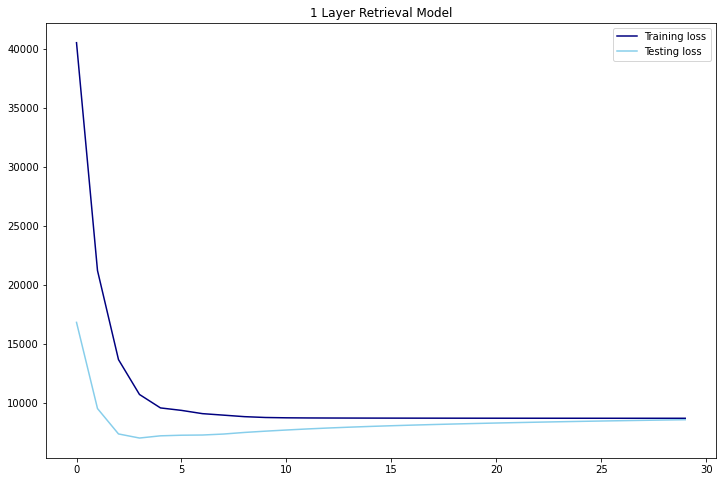

In [50]:
train_loss_1_layer = retrieval_1_layer_history.history['loss']
test_loss_1_layer = retrieval_1_layer_history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss_1_layer, label='Training loss', color='navy')
plt.plot(test_loss_1_layer, label='Testing loss', color='skyblue')
plt.title('1 Layer Retrieval Model')
plt.legend();

For the 1 layer model, it seems that the lowest testing loss was actually observed between the 3rd to 5th epoch.

It also seems that about 6-7 epochs is the best number to avoid overtraining. After that the model begins to overtrain. 

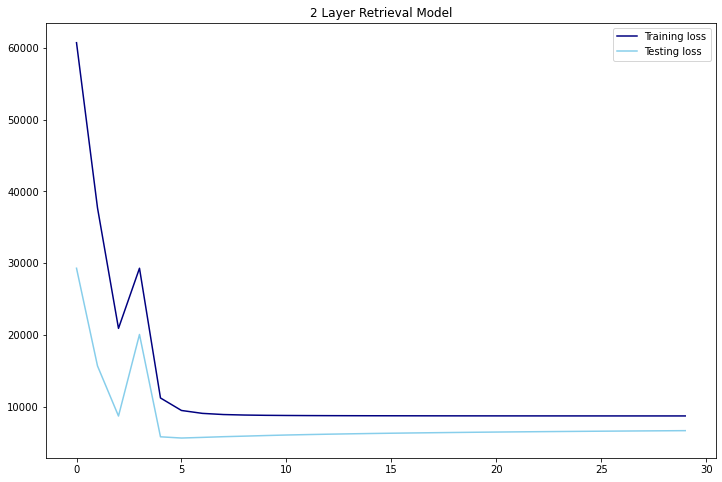

In [51]:
train_loss_2_layer = retrieval_2_layer_history.history['loss']
test_loss_2_layer = retrieval_2_layer_history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss_2_layer, label='Training loss', color='navy')
plt.plot(test_loss_2_layer, label='Testing loss', color='skyblue')
plt.title('2 Layer Retrieval Model')
plt.legend();

For the 2 layer model as well, it seems that the lowest testing loss was actually observed between the 3rd to 5th epoch. After 30 epochs, the model is not seeing overtraining, however it is approaching that as we see towards the end.

Now let's take a look at which model gave us a better performance.

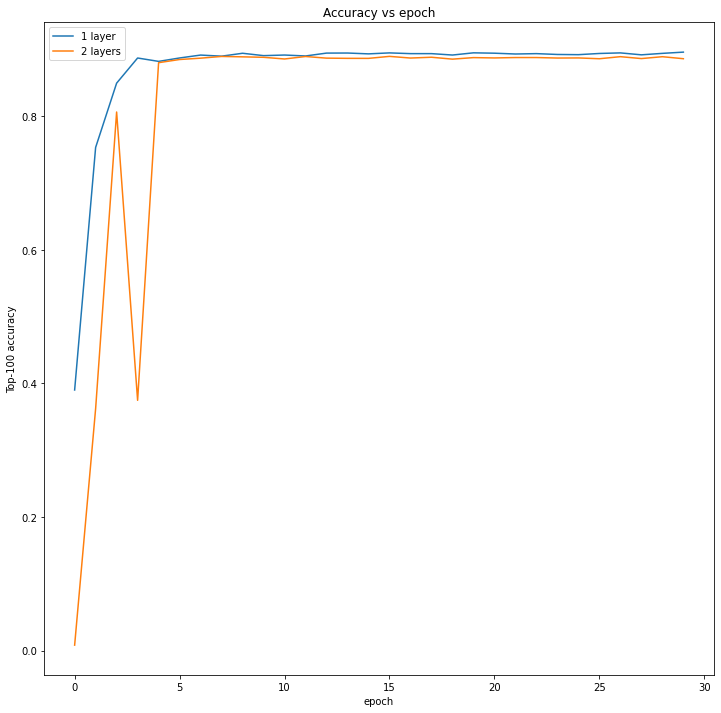

In [52]:
epochs = [_ for _ in range(num_epochs)]

plt.figure(figsize=(12,12))
plt.plot(epochs, retrieval_1_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.plot(epochs, retrieval_2_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy")
plt.legend();

In [88]:
accuracy_1_layer = retrieval_1_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
accuracy_2_layer = retrieval_2_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy for 1 layer model: {accuracy_1_layer:.4f}.")
print(f"Top-100 accuracy for 2 layer model: {accuracy_2_layer:.4f}.")

Top-100 accuracy for 1 layer model: 0.8960.
Top-100 accuracy for 2 layer model: 0.8861.


First of all, let's recall that the accuracy score for our first basic neural network model was **0.27**. We have massively improved this score just from adding 1 layer and adding in the additional context features to our model.

As we can see above, the `1 layer` model performs slightly better than the `2 layer` model. We would intuitively think that a deeper model will perform better, however, careful tuning is required for a deeper model to perform well.

An example of a hyperparameter that could be tuned is different optimizers, and different learning rates. There are a whole host of other hyper parameters that could be tuned as well.

For now, since the `1 layer` model has performed best, we will use that model going forward in this notebook. Let's add both the two scores into our `retrival_dict` to keep track of the scores.

In [89]:
retrieval_dict['model_name'].append('1 layer model')
retrieval_dict['model_name'].append('2 layer model')
retrieval_dict['top-100 accuracy'].append(0.8960)
retrieval_dict['top-100 accuracy'].append(0.8861)

Let's test querying the model for retrieving potential recommendations for a `userId`. For this we will make use of `BruteForce` as outlined in the tensorflow-recommender system guide.

In [54]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(retrieval_1_layer.\
                                                query_model.embedding_model.\
                                                user_embedding,
                                                k=100)

# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(1024), 
                       movies.batch(1024).map(retrieval_1_layer.\
                                              candidate_model.\
                                              embedding_model.\
                                              movie_id_embedding)
                      )
                     )
)

# Get recommendations for a random 'userId', 512
_, titles = index(tf.constant([512]))
print(f"Recommendations for user 512: {np.unique(titles)}")

Recommendations for user 512: [ 6448  6934 48738 67923]


Now we have recommendations for `userId` **512**. However, just for sanity's sake, lets check once to see if these are new titles that are being recommended, or if some of these titles have already been seen by this user.

In [55]:
# get a list of movieIds already watched by userId 512
seen_titles_512 = df.loc[df['userId'] == 512, 'movieId'].unique().tolist()

# defining a list of unique recommended titles for userId 512
unique_reco_titles = np.unique([title for title in titles.numpy()[0]])

# getting a list of repeated titles
repeated_title_reco = [title for title in unique_reco_titles if title in seen_titles_512]

if repeated_title_reco:
    for title in repeated_title_reco:
        print(f'{title} is a repeated title')
else:
    print(f'{len(repeated_title_reco)} recommendations are repeated.')

0 recommendations are repeated.


As we can see from the above output, it seems that the model has learnt to give unique recommendations on it's own. For further exploration, I found out that there is a method called [query_with_exclusions](https://www.tensorflow.org/recommenders/api_docs/python/tfrs/layers/factorized_top_k/TopK#query_with_exclusions), that works if we want only want to get recommendations that have not been seen before.

# Ranking Model

Previously, we created a basic `ranking_model` where we only used 2 features of the dataset:
1. `userId`
2. `movieId`

and the target: `rating`. In the following model, we are going to add all the features in our dataset, similar to what we did for the `retrieval` model in the hopes of improved performance.

Let's start out by first creating the dataset that we will need. This time we will need to use the `rating` feature, so we will create a new dataset to keep things neat.<br> 

*There may be other more efficient ways to convert a dataset to a tensor dataset, however, for use in a recommender system, I found that the guide used a `mapdataset` object. As such I have used the following technique to achieve the same.*

In [56]:
# creating a dictionary of all the features we need
ranking_dataset = {
    'movieId': df['movieId'].tolist(),
    'genres': df['genres'].tolist(),
    'title': df['title'].tolist(),
    'userId': df['userId'].tolist(),
    'timestamp': df['timestamp'].tolist(), 
    'rating': df['rating'].tolist()
}

# converting dictionary to tensor
ranking_dataset = tf.data.Dataset.from_tensor_slices(ranking_dataset)

# creating a mapdataset object
ranking_dataset = ranking_dataset.map(lambda x: {
    'movieId': x['movieId'],
    'genres': x['genres'],
    'title': x['title'],
    'userId': x['userId'],
    'timestamp': x['timestamp'],
    'rating': x['rating']
})

In [57]:
# sanity check to ensure we have a mapdataset object
ranking_dataset

<MapDataset element_spec={'movieId': TensorSpec(shape=(), dtype=tf.int32, name=None), 'genres': TensorSpec(shape=(), dtype=tf.string, name=None), 'title': TensorSpec(shape=(), dtype=tf.string, name=None), 'userId': TensorSpec(shape=(), dtype=tf.int32, name=None), 'timestamp': TensorSpec(shape=(), dtype=tf.int32, name=None), 'rating': TensorSpec(shape=(), dtype=tf.float32, name=None)}>

---

### Creating the RankingModel classes

In [58]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    # using previously defined and created user_id_model
    self.user_embedding = user_id_model

    # Compute embeddings for movies.
    # using previously defined and created movie_id_model
    self.movie_id_embedding = movie_id_model
    
    # using previously defined and created timestamp_embedding_model
    self.timestamp_embedding = timestamp_embedding_model
    self.normalized_timestamp = tf.keras.layers.Normalization(
        axis=None
    )

    self.normalized_timestamp.adapt(timestamps)
    
    # using previously defined and created genres_model
    self.genre_text_embedding = genres_model
    
    # using previously defined and created titles_model
    self.title_text_embedding = titles_model

    # Compute predictions.
    self.ratings = tf.keras.Sequential([
        # Learn multiple dense layers.
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        # Make rating predictions in the final layer.
        tf.keras.layers.Dense(1)
    ])

  def call(self, inputs):

    return self.ratings(tf.concat([
        self.user_embedding(inputs['userId']),
        self.movie_id_embedding(inputs['movieId']),
        self.timestamp_embedding(inputs['timestamp']),
        tf.reshape(self.normalized_timestamp(inputs['timestamp']), (-1, 1)),
        self.genre_text_embedding(inputs['genres']),
        self.title_text_embedding(inputs['title'])
    ], axis=1))

In [59]:
class MovielensModel_ranking(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def call(self, features)-> tf.Tensor:
    return self.ranking_model(features)
#         (features['userId'], 
#          features['movieId'],
#          features['timestamp'],
#          features['genres'],
#          features['title'],
#         ))

  def compute_loss(self, features, training=False)-> tf.Tensor:
    labels = features.pop("rating")

    rating_predictions = self(features)

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)

## Train, Test split

Now we are ready to train our `RankingModel`, let's do a train_test_split on our data.

In [60]:
# setting random seed
tf.random.set_seed(42)

# shuffling the dataset to create a "training" dataset
shuffled_ranking = ranking_dataset.shuffle(100_000,
                                           seed=42, 
                                           reshuffle_each_iteration=False
                                          )

# taking the first 80_836 ratings
ranking_train = shuffled_ranking.take(80_836)

# taking the next 20_000 ratings
ranking_test = shuffled_ranking.skip(80_836).take(20_000)


# caching the train and test dataset to speed up model fitting
cached_ranking_train = ranking_train.shuffle(100_000)\
                        .batch(8192).cache()
cached_ranking_test = ranking_test.batch(4096).cache()

In [61]:
# instantiate the movielens ranking model
ranking_model_1 = MovielensModel_ranking()

# compiling model with Adagrad optimzier, and a learning rate of 0.1
ranking_model_1.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01))

In [62]:
# fitting the ranking model
num_epochs = 300

ranking_history = ranking_model_1.fit(
    cached_ranking_train, 
    validation_data=cached_ranking_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=0
)

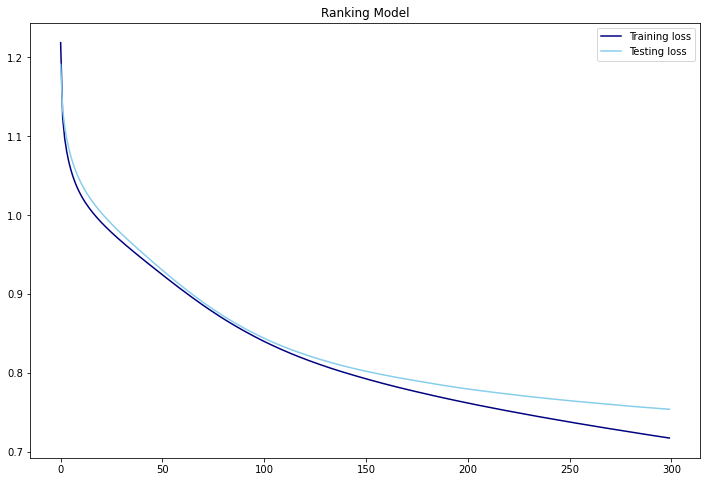

In [63]:
train_loss_ranking = ranking_history.history['loss']
test_loss_ranking = ranking_history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss_ranking, label='Training loss', color='navy')
plt.plot(test_loss_ranking, label='Testing loss', color='skyblue')
plt.title('Ranking Model')
plt.legend();

Here again we can see that the model has overfit on training data. Let's take a look at the `test_rmse`. From the previous notebook, our best `SVD` model, after tuning had a `rmse` error of **0.8442**.

In [64]:
ranking_model_1.evaluate(cached_ranking_test, return_dict=True)

5/5 [==============================] - 0s 15ms/step - root_mean_squared_error: 0.8862 - loss: 0.7796 - regularization_loss: 0.0000e+00 - total_loss: 0.7796


{'root_mean_squared_error': 0.8862238526344299,
 'loss': 0.754324734210968,
 'regularization_loss': 0,
 'total_loss': 0.754324734210968}

As we can see here, we have managed to get a `test_rmse` of **0.8862**.<br>

Keep in mind we have not tuned our model yet! All we have done is that we have added in all of the features available in our dataset, and added 1 more dense layer of 32 neurons as seen in the model architecture earlier. There is a high possibility that tuning the neural network model will most likely yield a model that has a high retrieval `accuracy`, and a low `rmse` of the rating prediction. 

Let's add this score into our `ranking_dict` to keep track of the scores.

### If there is time, I will tune this model in the next notebook.

In [92]:
ranking_dict['model_name'].append('3 layer model')
ranking_dict['top-100 accuracy'].append(0.8862)

Now let's test out how we can obtain predicted ratings for some movies for a random `userId` from our `RankingModel`. We will use user number **512** as a test `userId`, and we will use `movieId` **1085**, **1544**, and **1931** as test movieIds. This method is defined in the guide which can be referred to [here](https://www.tensorflow.org/recommenders/examples/basic_ranking).

* For the `timestamp` feature, we will use the current time. In an actual scenario, the recommender system would need to provide recommendations in realtime, which means that it will use the actual time currently.
* The format required for `timestamp` is `Unix` time. This can be obtained by using the `time.time()` method.

In [65]:
# defining an empty dictionary to store the predicted ratings
test_ratings = {}

# defining the movie ids
test_movie_ids = [1085, 1544, 1931]

# for loop to put the movieIds and other 
# required variables through 
for movie_id in test_movie_ids:
    test_ratings[movie_id] = ranking_model_1({
      'userId': np.array([512]),
      'movieId': np.array([movie_id]),
      'timestamp': np.array([round(time.time())]),
      'genres': movie_df.loc[movie_df['movieId'] == 1544, 'genres']\
        .values,
      'title': movie_df.loc[movie_df['movieId'] == 1544, 'title']\
        .values
  }).numpy()[0][0]
    
# for loop to print out the ratings for userId 512

print('Ratings for userId 512:')
for movie_id, score in sorted(test_ratings.items(), 
                              key=lambda x: x[1], 
                              reverse=True):
    print(f"{movie_id}: {score}")

Ratings for userId 512:
1931: 4.054357528686523
1085: 3.757417678833008
1544: 2.9500272274017334


We are able to obtain the ratings for the movies, just by passing in the `userId` and the `movieId` features. The rest of the information can be obtained from the dataset itself. Now, let's combine the prediction method for the `RetrievalModel` and the `RankingModel` into 1 custom function.

In [66]:
def get_top_movies(userID, num_of_movies=None):
    """This function accepts input of a userId (int), and outputs the 
    top 5 movies that should be recommender to them, with the predicted 
    rating the user will give. When loading the models, ensure that the 
    RetrievalModel is defined as 'retrieval_model', and the RankingModel 
    is definied as 'ranking_model. If this is not done, the function will 
    not work.'"""
    
    # defining userId
    userId = userID
    
    # Create a model that takes in raw query features, and
    index = tfrs.layers.factorized_top_k.BruteForce(retrieval_1_layer.\
                                                    query_model.embedding_model.\
                                                    user_embedding,
                                                    k=100)

    # recommends movies out of the entire movies dataset.
    index.index_from_dataset(
      tf.data.Dataset.zip((movies.batch(1024), 
                           movies.batch(1024).map(retrieval_1_layer.\
                                                  candidate_model.\
                                                  embedding_model.\
                                                  movie_id_embedding)
                          )
                         )
    )

    # Get recommendations for a random 'userId', 512
    _, titles = index(tf.constant([userId]))
    
    # takes the recommended movieIds and puts them through the ranking model
    
    test_movie_ids = [movie_id for movie_id in np.unique(titles)]
    
    timestamp = random.choice(df.loc[df['userId'] == 512, 'timestamp'].unique())
    pred_dict = {}
    pred_dict['title'] = [movie_df.loc[movie_df['movieId'] == id, 'title'].values[0] 
                            for id in test_movie_ids]
    pred_dict['predicted_rating'] = [ranking_model_1({
            'userId': np.array([userId]), 
            'movieId': np.array([movie_id]), 
            'timestamp': np.array([timestamp]), 
            'genres': movie_df.loc[movie_df['movieId'] == movie_id, 'genres'].values, 
            'title': movie_df.loc[movie_df['movieId'] == movie_id, 'title'].values
        }).numpy()[0][0] for movie_id in test_movie_ids]
    pred_dict['userId'] = [userId for _ in test_movie_ids]
    pred_dict['movieId'] = test_movie_ids
    pred_dict['genres'] = [movie_df.loc[movie_df['movieId'] == id, 'genres'].values[0] 
                            for id in test_movie_ids]
    pred_dict['timestamp'] = [timestamp for id in test_movie_ids]
    
    
    
    pred_df = pd.DataFrame(pred_dict)
    pred_df.sort_values(by='predicted_rating', ascending=False, inplace=True)
    
    if num_of_movies and len(pred_df) > num_of_movies:
        return pred_df.head(num_of_movies)[['title', 'predicted_rating','userId']]
    else:
        return pred_df[['title', 'predicted_rating','userId']]

Now that we have a function, let's test it out.

We will simulate a real-life scenario by doing the following things.
1. We will pass in a random `userId` value from our dataset. 
2. We will use a real time `timestamp` value in `UNIX` format.
3. We will output the time taken for functino to execute, and output the recommendations.

In [67]:
%%time
get_top_movies(random.choice([user for user in range(1, 611)]), num_of_movies=5)

CPU times: total: 3.48 s
Wall time: 1.28 s


,title,predicted_rating,userId
1,Unforgiven (1992),3.625554,140
7,"Face in the Crowd, A (1957)",3.604611,140
12,"11'09""01 - September 11 (2002)",3.560477,140
15,Hachiko: A Dog's Story (a.k.a. Hachi: A Dog's ...,3.552211,140
10,My Dinner with André (1981),3.485780,140


In [68]:
%%time
get_top_movies(random.choice([user for user in range(1, 611)]), num_of_movies=5)

CPU times: total: 2.94 s
Wall time: 776 ms


,title,predicted_rating,userId
3,Boiler Room (2000),3.862054,604
1,"Perfect Murder, A (1998)",3.756729,604
5,"Cercle Rouge, Le (Red Circle, The) (1970)",3.730356,604
4,"Das Experiment (Experiment, The) (2001)",3.606194,604
2,Out of Sight (1998),3.566495,604


In [69]:
%%time
get_top_movies(random.choice([user for user in range(1, 611)]), num_of_movies=5)

CPU times: total: 3.02 s
Wall time: 709 ms


,title,predicted_rating,userId
1,Easy Rider (1969),4.528473,544
2,Close Encounters of the Third Kind (1977),4.383904,544
0,"Secret of NIMH, The (1982)",4.205155,544
3,"Station Agent, The (2003)",4.167224,544


For each of the cells, we can observe 2 outputs:
1. Cpu Time and Wall Time
2. The table containing the top 5 recommended movies

To evaluate the time taken for a model to predict and output the recommendations, we will use wall time, as mentioned in the previous notebook [2. Surprise Models].

In that notebook we saw that ....

We can see that our Recommender System Neural Network takes an average of 1 second or so of wall time to predict and output the table of movies.

* Strategies to reduce the time further.
* Tuning
* user contextual features (age, occupation, user_country, etc)
* Next steps

In [72]:
(1.28+.709+.776)/3

0.9216666666666665

In [95]:
retrieval_df = pd.DataFrame(retrieval_dict)
retrieval_df

,model_name,top-100 accuracy
0,basic_retrival_model,0.001049
1,1 layer model,0.896000
2,2 layer model,0.886100


In [96]:
ranking_df = pd.DataFrame(ranking_dict)
ranking_df

,model_name,top-100 accuracy
0,basic_retrival_model,0.001049
1,3 layer model,0.886200


In [97]:
retrieval_df.to_csv('./datasets/retrieval_model_scores.csv', index=False)
ranking_df.to_csv('./datasets/ranking_model_scores.csv', index=False)

Retrieval, Ranking, and Post-Ranking

**One thing I need to figure out is how I can pass in the movie genres into the Neural Network. I will need to create embeddings for it, and then compile it into the model.**

## What are Embeddings?

They allow additionaly information to be inserted in your neural network. This can be an alternative to 1-hot-encoding. It gets impractical the more dimensionality you will have. 1 dummy variable for every variable may not be useful. It will increase the dimensionality of the data, however the hope is to improve the model score at the end of the day.

How to "train" the embedding layer?
What's the vocabulary size? Let's say you have 10 genres, so your input_dim is 10, and you can set the output_dim to be a vector with n number of rows. Let's say output_dim=4. It won't just be 0s and 1s either. Input length is just referring to the length of the sequence. So for me, it's just going to be 1, as 1 word = 1 feature for genre.

so this "neural network" has only 1 layer. It only kicks out the embeddings. It doesn't really do anything much, but you've created the embedding layer. 
Now you have a "lookup table" that is your embedding. 
so in the above example, we will have a table of 10 cols, and 4 rows. So an array of [1, 2] will return a "prediction". What it outputs is actually a bunch of random weights. You' can't really make sense of this. It will make sense if you compare it to the embedding layer weights. Be careful that this weights should not be trained, because they aren't meant to be treated as weights, but rather as lookup table.

In [70]:
results = {'retrieval_NN': ['1st_run', '2nd_run', '3rd_run'],
           'top-100 accuracy': [0.27, 0.86, 0.88],
           'ranking_NN': ['1st_run', '2nd_run', '3rd_run'],
           'rating_rmse': [1.1813, 0.9418, 0.8681]
          }

# the difference between the runs for retrieval is, I added deeper layers, and I added in all the features
# the difference between the runs for ranking is, I added 1 more deeper layer, and I added in all the features